In [3]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from langchain_groq import ChatGroq
import os
from pydantic import BaseModel, Field
load_dotenv()

True

In [4]:


model = ChatGroq(
        groq_api_key=os.getenv("GROQ_API_KEY"), # type: ignore
        model_name="Gemma2-9b-It",# type: ignore
        temperature=0.5 ## this is creative parameter
    )

In [ ]:
# model = ChatOpenAI(model='gpt-4o-mini')

In [26]:
class SentimentSchema(BaseModel):

    sentiment: Literal["positive", "negative","out of Context"] = Field(description='Sentiment of the review')

In [6]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')


In [27]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [19]:
prompt = 'What is the sentiment of the following review - The software too good'
structured_model.invoke(prompt).sentiment

'positive'

In [28]:
sample = {"review":"who is sachin Tendulkar?"}
prompt = (
    "Determine the sentiment of the given text ONLY if it is a valid product, service, or experience review. "
    "Valid reviews describe opinions, experiences, or evaluations. "
    "If the text is a question, unrelated statement, or otherwise not a review, respond with exactly 'out of context'.\n\n"
    f"Text:\n{sample['review']}\n"
    "Sentiment:"
)

structured_model.invoke(prompt).sentiment

'out of Context'

In [ ]:
prompt = 'What is the sentiment of the following review - The software too bad'
structured_model2.invoke(prompt)

DiagnosisSchema(issue_type='Bug', tone='angry', urgency='high')

In [21]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [34]:
def find_sentiment(state: ReviewState):

    prompt = (
        "Determine the sentiment of the given text ONLY if it is a valid product, service, or experience review. "
        "Valid reviews describe opinions, experiences, or evaluations. "
        "If the text is a question, unrelated statement, or otherwise not a review, respond with exactly 'out of context'.\n\n"
        f"Text:\n{state['review']}\n"
        "Sentiment:"
    )
    
    sentiment = structured_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis","out_of_context"]:

    if state['sentiment'] == 'positive':
        return 'positive_response'
    if state['sentiment'] == 'negative':
        return 'run_diagnosis'
    else:
        return 'out_of_context'
        
    
def positive_response(state: ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""
    
    response = model.invoke(prompt).content

    return {'response': response}

def run_diagnosis(state: ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}

def out_of_context(state: ReviewState):
    
    response = "The review is out of context. Please provide a valid product or service review."

    return {'response': response}
    

In [35]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)
graph.add_node('out_of_context', out_of_context)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)
graph.add_edge('out_of_context', END)

workflow = graph.compile()

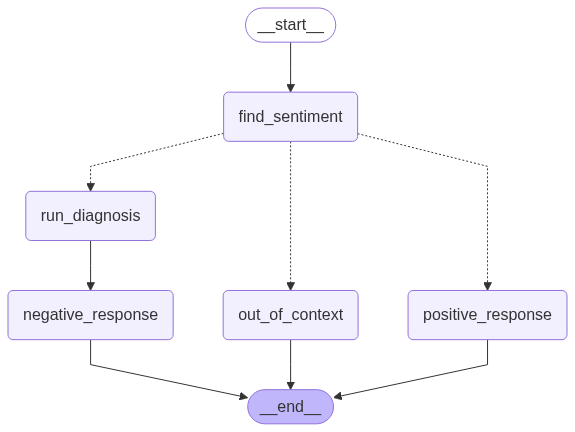

In [36]:
workflow

In [37]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'angry', 'urgency': 'high'},
 'response': "I understand you're frustrated with this bug, and I want to assure you that we take your issue very seriously.  \n\nHigh urgency means a lot to us, and we're committed to resolving it as quickly as possible. Can you please provide me with some more details about the bug so I can help investigate it further?  \n\nFor example, could you tell me:\n\n* **What exactly is happening?** (Please be as specific as possible.)\n* **What were you doing when the bug occurred?**\n* **Have you tried any troubleshooting steps already?**\n\nThe more information you can give me, the faster we can get this fixed for you. \n\nI apologize for the inconveni

In [38]:
intial_state={
    'review': "Who is Sachin Tendulkar?"
}
workflow.invoke(intial_state)

{'review': 'Who is Sachin Tendulkar?',
 'sentiment': 'out of Context',
 'response': 'The review is out of context. Please provide a valid product or service review.'}